In [ ]:
!pip install transformers==4.12.5 fugashi==1.1.0 ipadic==1.0.0 sentencepiece

In [1]:
import random
import glob
import pickle
from tqdm.auto import tqdm, trange
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification,AutoConfig,AdamW,T5Tokenizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
seed = 0
fix_seed(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#データのダウンロード
!wget https://www.rondhuit.com/download/ldcc-20140209.tar.gz 
#ファイルの解凍
!tar -zxf ldcc-20140209.tar.gz 

In [ ]:
!cat ./text/it-life-hack/it-life-hack-6342280.txt # ファイルを表示

In [ ]:
category_list = [
    'dokujo-tsushin',
    'it-life-hack',
    'kaden-channel',
    'livedoor-homme',
    'movie-enter',
    'peachy',
    'smax',
    'sports-watch',
    'topic-news'
]

In [ ]:
def train(model,loader):
    model.train() 
    train_loss = 0
    for batch in loader:
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)
        optimizer.zero_grad()
        output = model(b_input_ids,
                      attention_mask=b_input_mask, 
                      labels=b_labels)
        loss = output[0]
        loss = loss.to(torch.float32)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_loss += loss
    return train_loss


def validation(model,loader):
    model.eval()
    val_loss = 0
    with torch.no_grad(): 
        for batch in loader:
            b_input_ids = batch['input_ids'].to(device)
            b_input_mask = batch['attention_mask'].to(device)
            b_labels = batch['labels'].to(device)

            output = model(b_input_ids, 
                          attention_mask=b_input_mask,
                          labels=b_labels)
            val_loss += output[0]
    return val_loss

def test_report(model,loader):
    pred_result = []
    true_result = []
    model.eval()
    with torch.no_grad():
        for batch in loader:
            b_input_ids = batch['input_ids'].to(device)
            b_input_mask = batch['attention_mask'].to(device)
            b_labels = batch['labels'].to(device)
            
            output = model(b_input_ids, 
                            attention_mask=b_input_mask,
                            labels=b_labels)
            pred_labels = [np.argmax(pred.to('cpu').detach().numpy()) for pred in output[1]]
            pred_result.extend(pred_labels)
            true_result.extend(batch['labels'])
    return classification_report(true_result,pred_result,output_dict=True)

In [ ]:
# 参照 https://qiita.com/ku_a_i/items/ba33c9ce3449da23b503

class EarlyStopping:
    """earlystoppingクラス"""

    def __init__(self, patience=5, verbose=False, path='checkpoint_model.pth', threshold=10000):
        """引数：最小値の非更新数カウンタ、表示設定、モデル格納path"""

        self.patience = patience    #設定ストップカウンタ
        self.verbose = verbose      #表示の有無
        self.counter = 0            #現在のカウンタ値
        self.best_score = None      #ベストスコア
        self.early_stop = False     #ストップフラグ
        self.val_loss_min = np.Inf   #前回のベストスコア記憶用
        self.path = path             #ベストモデル格納path
        self.tloss_th = threshold   #学習ロスの閾値（指定しない場合は10000になり，事実上閾値なし）

    def __call__(self, train_loss, val_loss, model):
        """
        特殊(call)メソッド
        実際に学習ループ内で最小lossを更新したか否かを計算させる部分
        """
        score = -val_loss


        if self.best_score is None or train_loss>self.tloss_th:  #1Epoch目または閾値以上での処理
            self.best_score = score   #1Epoch目はそのままベストスコアとして記録する
            self.checkpoint(val_loss, model)  #記録後にモデルを保存してスコア表示する
        elif score < self.best_score:  # ベストスコアを更新できなかった場合
            self.counter += 1   #ストップカウンタを+1
            if self.verbose:  #表示を有効にした場合は経過を表示
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')  #現在のカウンタを表示する 
            if self.counter >= self.patience:  #設定カウントを上回ったらストップフラグをTrueに変更
                self.early_stop = True
        else:  #ベストスコアを更新した場合
            self.best_score = score  #ベストスコアを上書き
            self.checkpoint(val_loss, model)  #モデルを保存してスコア表示
            self.counter = 0  #ストップカウンタリセット

    def checkpoint(self, val_loss, model):
        '''ベストスコア更新時に実行されるチェックポイント関数'''
        if self.verbose:  #表示を有効にした場合は、前回のベストスコアからどれだけ更新したか？を表示
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)  #ベストモデルを指定したpathに保存
        self.val_loss_min = val_loss  #その時のlossを記録する

# 実験

In [2]:
MODEL_NAME="bandainamco-mirai/distilbert-base-japanese"
# MODEL_NAME = "cl-tohoku/bert-base-japanese-whole-word-masking"
# MODEL_NAME = "rinna/japanese-roberta-base"

## トークン化

In [ ]:
# トークナイザのロード
if MODEL_NAME =="bandainamco-mirai/distilbert-base-japanese":
    tokenizer = AutoTokenizer.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')
elif MODEL_NAME== "rinna/japanese-roberta-base":
    tokenizer = T5Tokenizer.from_pretrained("rinna/japanese-roberta-base")
else:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# 各データの形式を整える（参照：https://github.com/stockmarkteam/bert-book/blob/master/Chapter6.ipynb）
max_length = 256
dataset_for_loader = []
for label, category in enumerate(tqdm(category_list)):
    for file in glob.glob(f'./text/{category}/{category}*'):
        lines = open(file).read().splitlines()
        text = '\n'.join(lines[3:]) # ファイルの4行目からを抜き出す。
        encoding = tokenizer(
            text,
            max_length=max_length, 
            padding='max_length',
            truncation=True
        )
        encoding['labels'] = label # ラベルを追加
        encoding = { k: torch.tensor(v) for k, v in encoding.items() }
        dataset_for_loader.append(encoding)

In [ ]:
import pickle
# with open("livedoor_"+MODEL_NAME.replace("/","_")+"_tokenized.pkl","wb") as f:
#   pickle.dump(dataset_for_loader,f)

with open("livedoor_"+MODEL_NAME.replace("/","_")+"_tokenized.pkl","rb") as f:
    dataset_for_loader = pickle.load(f)

In [ ]:
print(dataset_for_loader[0])

## データセットの分割

In [ ]:
# データセットの分割
fix_seed(0)
random.shuffle(dataset_for_loader) # ランダムにシャッフル
n = len(dataset_for_loader)
n_train = int(0.6*n)
n_val = int(0.2*n)+n_train
dataset_train = dataset_for_loader[:n_train] # 学習データ
dataset_val = dataset_for_loader[n_train:n_val] # 検証データ
dataset_test = dataset_for_loader[n_val:] # テストデータ

## 学習

In [ ]:
all_results={}

for n in trange(25):
    # print('===== '+str(n)+" =====")
    fix_seed(n)

    earlystopping = EarlyStopping(patience=3, verbose=True)

    dataloader_train = DataLoader(
      dataset_train, batch_size=32, shuffle=True
    ) 
    dataloader_val = DataLoader(dataset_val, batch_size=256)
    dataloader_test = DataLoader(dataset_test, batch_size=256)

    # モデルの読み込み
    bert_sc = AutoModelForSequenceClassification.from_pretrained(
            MODEL_NAME,
            num_labels=9,
            output_attentions = False,
            output_hidden_states = False,
            )
    bert_sc.cuda()

    optimizer = AdamW(bert_sc.parameters(), lr=2e-5)

    for epoch in range(30):
        # print("epoch: "+str(epoch+1))
        train_loss = train(bert_sc,dataloader_train)
        val_loss = validation(bert_sc,dataloader_val)
        print("train loss: "+str(train_loss))
        # print("val loss: "+str(val_loss))

    earlystopping(val_loss, bert_sc) 
    if earlystopping.early_stop: 
        print("Early Stopping!")
        break
    bert_sc.load_state_dict(torch.load('checkpoint_model.pth'))
    print("loaded best model")
    all_results[n]=test_report(bert_sc,dataloader_test)


with open("testset_"+MODEL_NAME.replace("/","_")+"_livedoor.pkl","wb") as f:
    pickle.dump(all_results,f)
    print("saved tes_list")

In [ ]:
# import pickle
# with open("testset_"+MODEL_NAME.replace("/","_")+"_livedoor.pkl","wb") as f:
#   pickle.dump(all_results,f)
#   print("saved tes_list")

## スコア分布

In [3]:
import pickle
with open("scores/testset_"+MODEL_NAME.replace("/","_")+"_livedoor.pkl","rb")as f:
    l = pickle.load(f)

In [4]:
acc_lis = [result['accuracy'] for result in l.values()]
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

<AxesSubplot:ylabel='Count'>

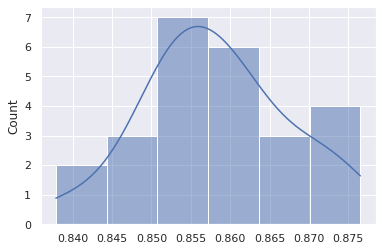

In [5]:
sns.histplot(acc_lis, kde=True)